<a href="https://colab.research.google.com/github/michaelsong4399/asteroseismology/blob/yihong/NNLightCurveF1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [1]:
!pip install lightkurve
!pip install astroquery
!pip install matplotlib
!pip install numpy
!pip install scipy
!pip install pandas
!pip install tensorflow
!pip install astropy

     |████████████████████████████████| 235kB 8.2MB/s 
     |████████████████████████████████| 22.3MB 1.4MB/s 
     |████████████████████████████████| 61kB 8.1MB/s 
     |████████████████████████████████| 256kB 44.5MB/s 
     |████████████████████████████████| 788kB 38.5MB/s 
     |████████████████████████████████| 6.5MB 30.7MB/s 
     |████████████████████████████████| 3.4MB 40.1MB/s 
     |████████████████████████████████| 368kB 48.4MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 25.3MB 1.5MB/s 
     |████████████████████████████████| 51kB 7.2MB/s 
     |████████████████████████████████| 3.2MB 48.9MB/s 
  Created wheel for fbpca: filename=fbpca-1.0-cp37-none-any.whl size=11376 sha256=2d614521e57437fa4f8864d3b1d8f69e890e4235f972ea152156954efa3e54ac
  Stored in directory: /root/.cache/pip/wheels/53/a2/dd/9b66cf53dbc58cec1e613d216689e5fa946d3e7805c30f60dc
  Created wheel for oktopus: filename=oktopus-0.1.2-cp37-none-any.whl size=12780 

In [2]:
import lightkurve as lk
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import math
import scipy
import pandas as pd 
from scipy import interpolate
#tf
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ML Model

## Cycle Configs

In [5]:
#Cycles
    #21
        #cycle_21 = []
        
        #Start 1 March 1976
        #End 1 September 1986
        
    #22
        #cycle_22 = [2446674.5,2450296.5]
        
        #Start: 1 September 1986 2446674.5
        #End: 1 August 1996 2450296.5
        
    #23
cycle_23 = [2450296.5,2454801.5]
        
        #Start: 1 August 1996 2450296.5
        #End: 1 December 2008 2454801.5
        
    #24
cycle_24 = [2454801.5,2458940.5]
        
        #Start: 1 December 2008 2454801.5
        #End: 1 May 2020 2458970.5
        #NOTE: Due to dataset limitation, only analyzed up to 2458940.5

cycle_2324 = [2450296.5,2458940.5]
        

## BiSON Surface Velocity - Import X

In [6]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits')

hdul.info()

tsdata = hdul[0].data
#         SIMPLE  =                    T / Written by IDL:  Tue Jan 19 11:22:20 2016      
#         BITPIX  =                  -64 /Real*8 (double precision)                       
#         NAXIS   =                    2 /                                                
#         NAXIS1  =                    2 /                                                
#         NAXIS2  =             24455519 /                                                
DSTART =        2442778.50000 #Data start (Julian)      1/1/1976 0:00:00                        
DEND   =        2458940.50000 #Data end (Julian)        4/1/2020 0:00:00                       
#         STATIONS= 'na ca cb su iz la lb mo' /Stations Used                              
#         METHOD  = 'waverage'           /Overlap Method                                  
#         CADENCE = '40      '           /Timeseries Cadence                              
#         N-THRES =                   80 /Noise Rejection Threshold                       
#         GAPFILL =                    1 /GapFill                                         
#         FILL    =             0.638866 /Duty Cycle   
#
#         ~2160 datapoints per day

Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   


In [7]:
def getSV(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[1]

def getSV_index(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,DSTART)
    
    #multiply by 2160 (2160 datapoints per day)
    cycle = np.multiply(cycle,2160)
    
    return tsdata[int(cycle[0]):int(cycle[1])].T[0]

#test
print(getSV(cycle_23))
print(getSV_index(cycle_23))

[ 0.52007627  0.87248993  0.11934945 ...  0.25079036 -1.0275805
 -0.95429337]
[2450296.50033958 2450296.50080254 2450296.50126551 ... 2454801.49915418
 2454801.49961714 2454801.50008011]


## Sunspot Number - Import Y

In [8]:
#sunspot_Day = np.genfromtxt('data/SN_d_tot_V2.0.csv',delimiter=';')
sunspot_Day = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_d_tot_V2.0.csv',delimiter=';')
SNSTART_Day = 2385070.5
SNEND_day = 2459000.5

#sunspot_Month = np.genfromtxt('data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = np.genfromtxt('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/SN_ms_tot_V2.0.csv',delimiter=';')
sunspot_Month = sunspot_Month[828:]

In [9]:
def getSN_Day(cycle):
    if cycle[1] >= SNEND_day:
        cycle[1] = SNEND_day
    cycle = np.subtract(cycle, SNSTART_Day)
    sn = sunspot_Day.T[4][int(cycle[0]):int(cycle[1])]
    
    npout = [[0,0]]
    for i in range(len(sn)):
        npout = np.append(npout,[[i+SNSTART_Day+cycle[0],sn[i]]],0)
    npout = npout[1:]
    return npout

def getSNAverage(cycle,length):
    
    npout = [[0,0]]
    total = 0
    valid_count = 0
    start = cycle[0][0]
    for i in range(len(cycle)):
        if cycle[i][1] >= 0:
            total += cycle[i][1]
            valid_count += 1
        if (i+1) % length < 1 or i == len(cycle)-1:
            if valid_count == 0:
              npout = np.append(npout,[[start,np.average(cycle)]],0)
            else:
              npout = np.append(npout,[[start,total/valid_count]],0)
            total = 0
            valid_count = 0
            if i == len(cycle)-1:
                break
            start = cycle[i+1][0]
    npout = npout[1:]
    return npout

#Test
getSN_Day(cycle_23)
getSNAverage(getSN_Day(cycle_23),365)

array([[2.45029650e+06, 1.45643836e+01],
       [2.45066150e+06, 6.19232877e+01],
       [2.45102650e+06, 1.21704110e+02],
       [2.45139150e+06, 1.69175342e+02],
       [2.45175650e+06, 1.53487671e+02],
       [2.45212150e+06, 1.78747945e+02],
       [2.45248650e+06, 1.29030137e+02],
       [2.45285150e+06, 7.85397260e+01],
       [2.45321650e+06, 5.33808219e+01],
       [2.45358150e+06, 3.17945205e+01],
       [2.45394650e+06, 1.95780822e+01],
       [2.45431150e+06, 6.09041096e+00],
       [2.45467650e+06, 2.98400000e+00]])

## LOI Luminosity - Import Pred_Y

In [10]:
#hdul = fits.open('data/allsites-alldata-waverage-fill.fits')
hdul = fits.open('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits')

hdul.info()

loidata = hdul[0].data

# variations at at most 2000 ppm
# cadence: 60s
LOI_DSTART =        2450174.50000 #Data start (Julian)      1 April 1996 0:00:00                        
LOI_DEND   =        2458589.50000 #Data end (Julian)        15 April 2019 0:00:00  

#    #23
# cycle_23 = [2450296.5,2454801.5]
        
#         #Start: 1 August 1996 2450296.5
#         #End: 1 December 2008 2454801.5
        
#     #24
# cycle_24 = [2454801.5,2458940.5]
        
#         #Start: 1 December 2008 2454801.5
#         #End: 1 May 2020 2458970.5


Filename: /content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Data/ts_loi.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (12117600,)   float64   


In [11]:
#Prepare LOI
loidatax = np.arange(LOI_DSTART,LOI_DEND,1/1440)
loifull = np.append([loidatax],[loidata],0).T
print(loifull.shape)

(12117600, 2)


In [12]:
def getLOI(cycle):
    #Subtract starting date
    cycle = np.subtract(cycle,LOI_DSTART)
    
    #multiply by 1440 (1440 datapoints per day)
    cycle = np.multiply(cycle,1440)
    
    return loifull[int(cycle[0]):int(cycle[1])]

print(getLOI([2450174.5,2458590.5]).shape)

(12117600, 2)


## Helper Functions

In [ ]:
#Interpolation
def interpolate(data, smoothness):
    from scipy import interpolate
    x_new = np.linspace((data[0][0])-1,int(data[-1][0])+1,smoothness)
    a_BSpline = interpolate.make_interp_spline(data.T[0],data.T[1])
    y_new = a_BSpline(x_new)
    return x_new,y_new

In [ ]:
def normalize1D(data):
    return np.divide(np.nan_to_num(data,np.nanmean(data)),np.nanmax(data))

In [ ]:
def normalize2D(data):
    for i in range(int(len(data))):
        if np.isnan(data[i]).all():
            data[i] = np.nan_to_num(data[i],np.nanmean(data[i-1]))
        else:
            data[i] = np.nan_to_num(data[i],np.nanmean(data[i-1] if i > 0 else 0))
            data[i] = np.divide(data[i],np.nanmax(data[i]))
    return data

In [ ]:
def removeNans(data):
  arr = data.T[1]
  arr[arr == 0] = 'nan'
  return [data.T[0],arr].T

## Lightkurve Asteroseismology - Functions

In [ ]:
def getPeriodogram(time,freq,numax=-1):
    lc = lk.LightCurve(time=time.tolist(),flux=freq.tolist())
    lc = lc.remove_nans()
    if numax != -1:
        pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=numax-600, maximum_frequency=numax+1000)
    else:
        pg = lc.to_periodogram(method='lombscargle', normalization='psd',minimum_frequency=500, maximum_frequency=5000)
    #ax = pg.plot()
    return pg

pg = getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000])[0:5]
print(pg)

LombScarglePeriodogram(ID: None)


In [ ]:
def getPower(pg):
    pg_data = pg.to_table()
    data = np.array(pg_data['power']).T#.tolist()
    return data

ptest = getPower(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000]))[0:5]
print(ptest)

[1.63584896e-04 5.28813580e-05 2.22539936e-05 5.47090798e-05
 1.00064050e-05]


In [ ]:
def getNumax(pg):
  snr = pg.flatten()
  seis = snr.to_seismology()
  numax = int(str(seis.estimate_numax())[:-6])

  return numax

nutest = getNumax(getPeriodogram(getSV_index(cycle_23)[110000:120000],getSV(cycle_23)[110000:120000]))
print(nutest)

3105


In [ ]:
def tsPower(time,freq,length,interval,BiSON=False):
  if BiSON:
      length = int(length * 2160)
      interval = int(interval * 2160)
  else:
      length = int(length * 1440)
      interval = int(interval * 1440)
  
  numax = getNumax(getPeriodogram(time[:500000],freq[:500000]))

  check = True
  for start in range(0,len(time),interval):
      if start + length >= len(time):
          length = len(time) - start
      if check:
        check = False
        npout1d = np.array([getPower(getPeriodogram(time[start:start+length],freq[start:start+length],numax))])
      else:
        temp = np.array([getPower(getPeriodogram(time[start:start+length],freq[start:start+length],numax))])
        if temp.size == npout1d[-1].size:
          npout1d = np.append(npout1d,temp,0)


  return npout1d,numax

In [ ]:
def toLightCurve(time,freq):
  return lk.LightCurve(time=time,flux=freq)

In [ ]:
def toData(lc):
    lc_data = lc.to_table()
    data = np.array(lc_data['flux'])
    


## Model Preprocessing

### BiSON Surface Velocity - Preprocess X

In [ ]:
BiSON_ts_23,BiSON_numax_23= tsPower(getSV_index(cycle_23),getSV(cycle_23),90,30,True)

In [ ]:
print(BiSON_numax_23,BiSON_ts_23.shape)
print(BiSON_ts_23[:5])

3015 (148, 12442)
[[1.03979968e-05 5.29660439e-05 6.79584287e-05 ... 7.36963116e-06
  1.04668014e-05 6.01689644e-05]
 [9.34218945e-06 3.68326689e-05 5.81982251e-05 ... 1.62203664e-05
  9.01618981e-07 2.32030182e-05]
 [5.72219990e-05 3.62517996e-05 4.45341103e-05 ... 2.90240840e-05
  7.96319713e-05 5.88030316e-05]
 [1.27027056e-04 6.99308610e-05 7.00852551e-05 ... 9.37977980e-06
  9.25918224e-05 3.92324547e-05]
 [2.86466009e-05 1.19806514e-04 3.20532445e-05 ... 8.00815947e-05
  3.41505514e-05 2.50407341e-05]]


In [ ]:
BiSON_ts_24,BiSON_numax_24 = tsPower(getSV_index(cycle_24),getSV(cycle_24),90,30,True)

In [ ]:
print(BiSON_numax_24,BiSON_ts_24.shape)
print(BiSON_ts_24[:5])

3025 (135, 12442)
[[2.18577106e-03 6.16210276e-03 2.21387947e-03 ... 2.16143741e-04
  2.61870979e-06 2.80215805e-05]
 [1.17659371e-03 5.62225820e-03 1.68746566e-03 ... 5.12118329e-05
  4.57678851e-05 4.06941549e-05]
 [3.24292581e-03 4.64330741e-04 5.91899543e-05 ... 3.51976427e-05
  2.36395466e-05 1.84987228e-04]
 [7.13741373e-04 1.64587826e-03 5.02287057e-04 ... 5.40686663e-05
  7.04134051e-05 4.22713209e-05]
 [5.00993037e-04 5.98173391e-04 1.36099010e-03 ... 1.77870671e-06
  1.17520176e-04 1.69768958e-05]]


In [ ]:
BiSON_ts_full,BiSON_numax_full = tsPower(getSV_index(cycle_2324),getSV(cycle_2324),90,30,True)

In [ ]:
print(BiSON_numax_full,BiSON_ts_full.shape)
print(BiSON_ts_full[:5])

3015 (286, 12442)
[[1.03979968e-05 5.29660439e-05 6.79584287e-05 ... 7.36963116e-06
  1.04668014e-05 6.01689644e-05]
 [9.34218945e-06 3.68326689e-05 5.81982251e-05 ... 1.62203664e-05
  9.01618981e-07 2.32030182e-05]
 [5.72219990e-05 3.62517996e-05 4.45341103e-05 ... 2.90240840e-05
  7.96319713e-05 5.88030316e-05]
 [1.27027056e-04 6.99308610e-05 7.00852551e-05 ... 9.37977980e-06
  9.25918224e-05 3.92324547e-05]
 [2.86466009e-05 1.19806514e-04 3.20532445e-05 ... 8.00815947e-05
  3.41505514e-05 2.50407341e-05]]


### Sunspot Number - Preprocess Y

In [ ]:
SN_DELETE = -3

In [ ]:
SN_ts_23 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_23),0),30)[:SN_DELETE]
print(SN_ts_23.shape)

(148, 2)


In [ ]:
SN_ts_24 = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_24),0),30)[:SN_DELETE]
print(SN_ts_24.shape)

(135, 2)


In [ ]:
SN_ts_full = getSNAverage(np.ma.masked_equal(getSN_Day(cycle_2324),0),30)[:SN_DELETE]
print(SN_ts_full.shape)

(286, 2)


### LOI Luminosity - Preprocess Pred_Y

In [ ]:
print(getLOI(cycle_23).shape)
print(getLOI(cycle_23)[:10])

(6487200, 2)
[[ 2.45029650e+06 -2.08807224e-04]
 [ 2.45029650e+06 -1.99935382e-04]
 [ 2.45029650e+06 -2.12478601e-04]
 [ 2.45029650e+06 -2.09473520e-04]
 [ 2.45029650e+06 -2.38117448e-04]
 [ 2.45029650e+06 -2.55843421e-04]
 [ 2.45029650e+06 -2.29274237e-04]
 [ 2.45029650e+06 -2.39407792e-04]
 [ 2.45029651e+06 -2.34207347e-04]
 [ 2.45029651e+06 -1.84112930e-04]]


In [ ]:
LOI_ts_23,LOI_numax_23= tsPower(getLOI(cycle_23).T[0],getLOI(cycle_23).T[1],90,30)

In [ ]:
print(LOI_numax_23,LOI_ts_23.shape)
print(LOI_ts_23[0:5])

3135 (148, 12442)
[[2.90967053e-13 5.74977068e-13 1.84570823e-13 ... 5.10627338e-15
  6.43127798e-16 1.08807813e-13]
 [1.35447485e-13 5.78911594e-13 2.80072719e-13 ... 5.23836402e-14
  6.99206514e-14 5.95356905e-15]
 [9.44777825e-14 5.52449633e-14 7.36447570e-13 ... 8.94679500e-14
  3.91803577e-14 1.97046697e-14]
 [2.81269308e-14 3.25171329e-14 3.48045210e-13 ... 2.37893347e-13
  2.65631315e-14 2.91629728e-14]
 [1.40729347e-13 3.60212653e-14 4.01436433e-13 ... 1.67769600e-13
  9.98741958e-14 4.24867664e-14]]


In [ ]:
LOI_ts_24,LOI_numax_24= tsPower(getLOI(cycle_24).T[0],getLOI(cycle_24).T[1],90,30)

In [ ]:
print(LOI_numax_24,LOI_ts_24.shape)
print(LOI_ts_24[0:5])

3125 (124, 12442)
[[1.22759802e-13 1.05065790e-14 5.39679140e-14 ... 1.53897234e-14
  2.64453164e-14 1.21345111e-13]
 [1.17943064e-13 4.11838551e-13 3.49158538e-13 ... 1.55539243e-13
  2.51200152e-14 1.10986065e-13]
 [2.10667055e-13 4.92489719e-13 1.28134575e-13 ... 6.81037481e-14
  5.29893794e-14 6.81585689e-14]
 [3.66371866e-14 1.17594388e-12 1.28265368e-13 ... 1.10979573e-13
  1.24778388e-15 1.52842913e-13]
 [1.56761895e-13 1.56913231e-13 5.91421666e-13 ... 3.09191164e-14
  6.42176783e-14 4.39267055e-14]]


In [ ]:
LOI_ts_full,LOI_numax_full= tsPower(getLOI(cycle_2324).T[0],getLOI(cycle_2324).T[1],90,30)

In [ ]:
print(LOI_numax_full,LOI_ts_full.shape)
print(LOI_ts_full[0:5])

3135 (274, 12442)
[[2.90967053e-13 5.74977068e-13 1.84570823e-13 ... 5.10627338e-15
  6.43127798e-16 1.08807813e-13]
 [1.35447485e-13 5.78911594e-13 2.80072719e-13 ... 5.23836402e-14
  6.99206514e-14 5.95356905e-15]
 [9.44777825e-14 5.52449633e-14 7.36447570e-13 ... 8.94679500e-14
  3.91803577e-14 1.97046697e-14]
 [2.81269308e-14 3.25171329e-14 3.48045210e-13 ... 2.37893347e-13
  2.65631315e-14 2.91629728e-14]
 [1.40729347e-13 3.60212653e-14 4.01436433e-13 ... 1.67769600e-13
  9.98741958e-14 4.24867664e-14]]


## Align Dims

In [ ]:
# Cycle 23 Dims
print("Cycle 23 Dims")
try:
  print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)
except:
  pass
print()

# Cycle 24 Dims
print("Cycle 24 Dims")
try:
  print(BiSON_ts_24.shape,SN_ts_24.shape,LOI_ts_24.shape)
except:
  pass
print()

# Full Cycle Dims
print("Cycle FULL Dims")
try:
  print(BiSON_ts_full.shape,SN_ts_full.shape,LOI_ts_full.shape)
except:
  pass
print()

Cycle 23 Dims
(148, 12442) (148, 2) (148, 12442)

Cycle 24 Dims
(135, 12442) (135, 2) (124, 12442)

Cycle FULL Dims
(286, 12442) (286, 2) (274, 12442)



In [ ]:
#Fitting dims to LOI due to missing end of cycle 24
BiSON_ts_24_fit = BiSON_ts_24[:len(LOI_ts_24)]
SN_ts_24_fit = SN_ts_24[:len(LOI_ts_24)]

BiSON_ts_full_fit = BiSON_ts_full[:len(LOI_ts_full)]
SN_ts_full_fit = SN_ts_full[:len(LOI_ts_full)]

In [ ]:
# Test Fitted Dims
# Cycle 23 Dims
print("Cycle 23 Dims")
try:
  print(BiSON_ts_23.shape,SN_ts_23.shape,LOI_ts_23.shape)
except:
  pass
print()

# Cycle 24 Dims
print("Cycle 24 Dims")
try:
  print(BiSON_ts_24_fit.shape,SN_ts_24_fit.shape,LOI_ts_24.shape)
except:
  pass
print()

# Full Cycle Dims
print("Cycle FULL Dims")
try:
  print(BiSON_ts_full_fit.shape,SN_ts_full_fit.shape,LOI_ts_full.shape)
except:
  pass
print()

Cycle 23 Dims
(148, 12442) (148, 2) (148, 12442)

Cycle 24 Dims
(124, 12442) (124, 2) (124, 12442)

Cycle FULL Dims
(274, 12442) (274, 2) (274, 12442)



## Model Architecture

In [ ]:
#Test_Normalize
print(normalize1D(SN_ts_full_fit.T[1])[0:10])
print(np.max(normalize2D(BiSON_ts_full_fit)))
print(normalize2D(BiSON_ts_full_fit)[0:2])

[0.07982504 0.07996173 0.02870421 0.14460016 0.09997657 0.05194095
 0.07927829 0.0763737  0.11193123 0.1154477 ]
1.0
[[2.83240377e-04 1.44278966e-03 1.85118070e-03 ... 2.00748005e-04
  2.85114608e-04 1.63899648e-03]
 [2.37534598e-04 9.36507790e-04 1.47974863e-03 ... 4.12419191e-04
  2.29245728e-05 5.89960162e-04]]


In [ ]:
#Load Data
train_x = normalize2D(BiSON_ts_full_fit)
train_y = normalize1D(SN_ts_full_fit.T[1])
test_x = normalize2D(BiSON_ts_24_fit)
test_y = normalize1D(SN_ts_24_fit.T[1])
print(np.max(train_x),np.max(train_y),np.max(test_x),np.max(test_y))

1.0 1.0 1.0 1.0


In [ ]:
# tf.test.gpu_device_name() # No GPU Sad :v
keras.backend.clear_session()
# model = models.Sequential()

# model.add(layers.Conv1D(1024, 1, activation='relu',batch_input_shape=train_x.shape))
# model.add(layers.Dense(128))
# model.add(layers.Conv1D(32, 1, activation='relu'))
# model.add(layers.Dense(1,activation="sigmoid"))

# model.summary()

model = models.Sequential()
#model.add(layers.Conv1D(filters=16, kernel_size=1, activation='relu', batch_input_shape=(train_x.shape)))

#model.add(layers.Embedding(input_dim=64, output_dim=16))
model.add(layers.Dense(1024, activation='relu', input_shape=(train_x.shape)))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 274, 1024)         12741632  
_________________________________________________________________
dense_1 (Dense)              (None, 274, 512)          524800    
_________________________________________________________________
dense_2 (Dense)              (None, 274, 128)          65664     
_________________________________________________________________
dense_3 (Dense)              (None, 274, 16)           2064      
_________________________________________________________________
dense_4 (Dense)              (None, 274, 1)            17        
Total params: 13,334,177
Trainable params: 13,334,177
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [ ]:
history = model.fit(train_x, train_y, epochs=20,
                   validation_data=(test_x, test_y))

Epoch 1/20
9/9 [==============================] - 1s 103ms/step - loss: 0.0848 - accuracy: 0.0000e+00 - val_loss: 0.0927 - val_accuracy: 0.0000e+00
Epoch 2/20
9/9 [==============================] - 1s 89ms/step - loss: 0.0423 - accuracy: 0.0000e+00 - val_loss: 0.2101 - val_accuracy: 0.0000e+00
Epoch 3/20
9/9 [==============================] - 1s 89ms/step - loss: 0.0325 - accuracy: 0.0027 - val_loss: 0.1828 - val_accuracy: 0.0000e+00
Epoch 4/20
9/9 [==============================] - 1s 89ms/step - loss: 0.0139 - accuracy: 0.0027 - val_loss: 0.1449 - val_accuracy: 0.0000e+00
Epoch 5/20
9/9 [==============================] - 1s 87ms/step - loss: 0.0118 - accuracy: 0.0027 - val_loss: 0.1247 - val_accuracy: 0.0000e+00
Epoch 6/20
9/9 [==============================] - 1s 89ms/step - loss: 0.0073 - accuracy: 0.0045 - val_loss: 0.1476 - val_accuracy: 0.0000e+00
Epoch 7/20
9/9 [==============================] - 1s 87ms/step - loss: 0.0040 - accuracy: 0.0021 - val_loss: 0.1447 - val_accuracy: 0

## Model Prediction

In [ ]:
# Load Prediction Data
pred_BiSON = normalize2D(BiSON_ts_full_fit)
pred_LOI = normalize2D(LOI_ts_full)
print(np.max(pred_BiSON),np.max(pred_LOI))

1.0 1.0


In [ ]:
pred_BiSON = model.predict(pred_BiSON).reshape(-1)
print(pred_BiSON[0:15])
pred_LOI = model.predict(pred_LOI).reshape(-1)
print(pred_LOI[0:15])
# for i in range(int(len(pred_LOI)/2),len(pred_LOI)):
#   if pred_LOI[i] >= 0.75:
#     pred_LOI[i] = pred_LOI[i-1]

[0.08608574 0.06433015 0.05607313 0.13796587 0.10360704 0.05254282
 0.07603002 0.07604266 0.11533187 0.1017675  0.09486323 0.08252796
 0.13330986 0.25467518 0.13417147]
[0.3059213  0.31286213 0.21370529 0.21068098 0.17576645 0.21517669
 0.27143964 0.28036088 0.16532177 0.17044093 0.17582987 0.25228053
 0.45442158 0.34959778 0.28196937]


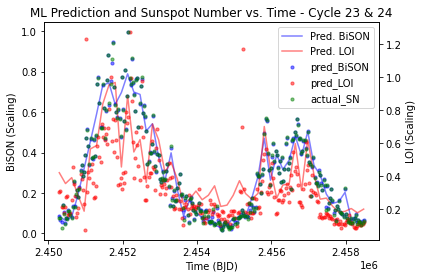

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('BiSON (Scaling)')
axis_1.scatter(SN_ts_full_fit.T[0],pred_BiSON, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([SN_ts_full_fit.T[0],pred_BiSON]).T,50)
axis_1.plot(x1_ITP, y1_ITP, c='blue', alpha=0.5, label = "Pred. BiSON")

# #Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('LOI (Scaling)')
axis_2.scatter(SN_ts_full_fit.T[0],pred_LOI, s = 10, c='red', alpha=0.5, label="pred_LOI")
x2_ITP, y2_ITP = interpolate(np.array([SN_ts_full_fit.T[0],pred_LOI]).T,50)
axis_1.plot(x2_ITP, y2_ITP, c='red', alpha=0.5, label = "Pred. LOI")

#Axis 3
axis_3 = axis_1.twinx()
axis_3.axis("off")
axis_3.set_ylabel('SN')
axis_3.scatter(SN_ts_full_fit.T[0],SN_ts_full_fit.T[1], s = 10, c='green', alpha=0.5, label="actual_SN")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.savefig('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Graphs/BiSON_LOI_SN.png')
plt.show()

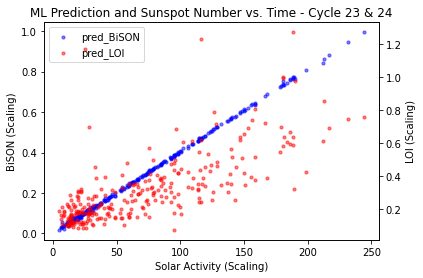

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Solar Activity (Scaling)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.set_ylabel('BiSON (Scaling)')
axis_1.scatter(SN_ts_full_fit.T[1],pred_BiSON, s = 10, c='blue', alpha=0.5, label="pred_BiSON")

#Axis 2
axis_2 = axis_1.twinx()
axis_2.set_ylabel('LOI (Scaling)')
axis_2.scatter(SN_ts_full_fit.T[1],pred_LOI, s = 10, c='red', alpha=0.5, label="pred_LOI")

# #Axis 3
# axis_3 = axis_1.twinx()
# axis_3.axis("off")
# axis_3.set_ylabel('SN')
# axis_3.scatter(datax_SN,datay_SN, s = 10, c='green', alpha=0.5, label="actual_SN")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
# lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 #+ lines_3
labels = labels_1 + labels_2 #+ labels_3
axis_1.legend(lines, labels, loc=0)

#Show Plot
#plt.savefig('Graphs/C23_Numax_SSN_Time.png')
plt.savefig('/content/drive/MyDrive/Korea Research - Yihong Song and Rohit Prasanna/DSHS & AOS Physics Research Collaboration 2020/Project/Jr:Sr Project/Graphs/BiSON_LOI_SN.png')
plt.show()

In [ ]:
sn_ts_full_fit_norm = normalize1D(SN_ts_full_fit.T[1])
BiSONxSN_mse = np.sqrt(mean_squared_error(sn_ts_full_fit_norm,pred_BiSON))
BiSONxSN_mae = mean_absolute_error(sn_ts_full_fit_norm,pred_BiSON)
print("BiSON vs. Actual - Mean Sq. Error, Mean Abs. Error")
print(BiSONxSN_mse,BiSONxSN_mae)

BiSON vs. Actual - Mean Sq. Error, Mean Abs. Error
0.006525118279256344 0.005006905047524024


In [ ]:
LOIxSN_mse = np.sqrt(mean_squared_error(sn_ts_full_fit_norm,pred_LOI))
LOIxSN_mae = mean_absolute_error(sn_ts_full_fit_norm,pred_LOI)
print("LOI vs. Actual - Mean Sq. Error, Mean Abs. Error")
print(LOIxSN_mse,LOIxSN_mae)

LOI vs. Actual - Mean Sq. Error, Mean Abs. Error
0.16007785086519294 0.11391995409761316


In [ ]:
BiSONxLOI_mse = np.sqrt(mean_squared_error(pred_BiSON,pred_LOI))
BiSONxLOI_mae = mean_absolute_error(pred_BiSON,pred_LOI)
print("BiSON vs. LOI - Mean Sq. Error, Mean Abs. Error")
print(BiSONxLOI_mse,BiSONxLOI_mae)

BiSON vs. LOI - Mean Sq. Error, Mean Abs. Error
0.15933391 0.112988226


In [ ]:
def getData(koi_name):
  search_result = lk.search_lightcurve(koi_name, author='Kepler', cadence="short")
  lc_test = search_result.download_all().stitch()
  lc_test = lc_test.fill_gaps()
  lc_table = lc_test.to_table()
  lc_array = np.array(lc_table['flux'])
  lcdatax = np.arange(0,len(lc_array)/1440,1/1440)
  lcfull = np.append([lcdatax],[lc_array],0).T
  return lcfull

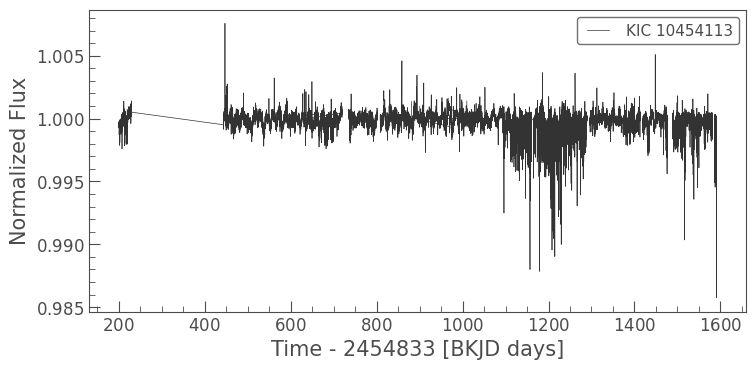

In [ ]:
search_result = lk.search_lightcurve('KIC 10454113', author='Kepler', cadence="short")
search_result
lc_test = search_result.download_all().stitch()
lc_test.plot()

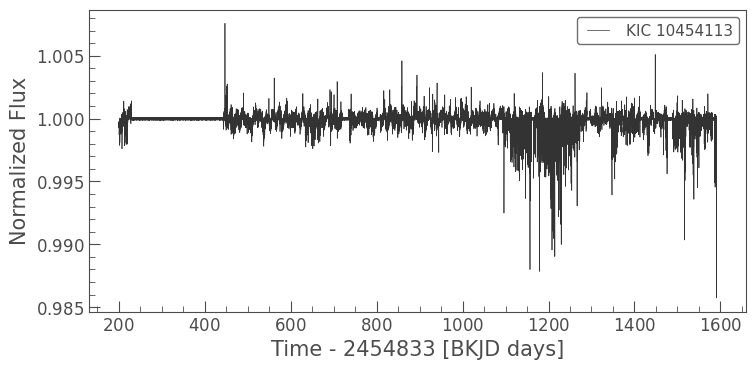

In [ ]:
lc_test = lc_test.fill_gaps()
lc_test.plot()

In [ ]:
Dlc_table = lc_test.to_table()
lc_array = np.array(lc_table['flux'])
print(lc_array)

In [ ]:
lcdatax = np.arange(0,len(lc_array)/1440,1/1440)
lcfull = np.append([lcdatax],[lc_array],0).T
print(lcfull.shape)

(1996170, 2)


In [ ]:
print(lcfull[-1])

[1.38622847e+03 1.00039232e+00]


In [ ]:
lc_power, lc_numax = tsPower(lcfull.T[0],lcfull.T[1],90,30)

In [ ]:
print(lc_power.shape,lc_numax)

(44, 7776) 1425


In [ ]:
lc_power_norm = normalize2D(lc_power)
print(np.max(lc_power_norm))

1.0


In [ ]:
pred_lc = model.predict(lc_power_norm[9:]).reshape(-1)
print(pred_lc.shape)
print(pred_lc)

(35,)
[2.1501856 2.1978247 2.218618  1.9813035 1.8138002 1.6447774 1.7670627
 1.3543344 1.6227567 1.4145533 1.6896728 1.8097239 1.6240644 2.0843878
 2.0923507 1.9381614 2.283571  2.4614487 2.109753  1.9923794 2.4358625
 2.504476  2.693074  2.2238019 2.4378045 2.00395   1.5316311 2.0904558
 1.6939368 1.8036245 1.837662  1.5059265 2.7730196 2.3647003 2.3227234]


<function matplotlib.pyplot.show>

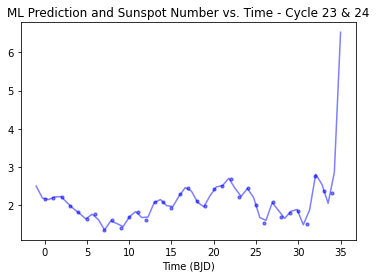

In [ ]:
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

lc_testx = np.arange(0,int(len(pred_lc)))

#Axis 1
plt.autoscale(enable=True, axis='both', tight=None)
plt.scatter(lc_testx,pred_lc, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc]).T,50)
plt.plot(x1_ITP, y1_ITP, c='blue', alpha=0.5, label = "Pred. BiSON")

plt.show

In [ ]:
lcdata3 = getData("KIC 6116048")

In [ ]:
lc_power, lc_numax = tsPower(lcdata3.T[0],lcdata3.T[1],90,30)

In [ ]:
lc_power_norm = normalize2D(lc_power)
print(np.max(lc_power_norm))

1.0


In [ ]:
pred_lc = model.predict(lc_power_norm[9:]).reshape(-1)
print(pred_lc.shape)
print(pred_lc)

(36,)
[0.5277961  0.63132465 0.40478465 0.42059588 0.5209544  0.7009002
 1.031577   0.7302094  0.58843035 0.5559162  0.57662654 0.58658266
 0.5535707  0.4052446  0.38021135 0.54982436 1.748396   1.4241097
 2.086725   1.1885546  1.8470598  1.8879963  1.9531791  1.8862461
 1.4063263  1.131757   1.1278707  1.4685751  1.067278   1.2002715
 1.1034241  0.6847471  0.71507204 1.2039894  1.3913287  1.1852996 ]


In [ ]:
lcdata4 = getData("KIC 12009504")

In [ ]:
lc_power2, lc_numax2 = tsPower(lcdata4.T[0],lcdata4.T[1],90,30)

In [ ]:
lc_power_norm2 = normalize2D(lc_power2)
print(np.max(lc_power_norm2))
pred_lc2 = model.predict(lc_power_norm2[9:-2]).reshape(-1)
print(pred_lc2.shape)
print(pred_lc2)

1.0
(36,)
[1.0906223  1.0631001  1.0119612  1.1853065  1.2532316  0.87308747
 0.9431411  0.9877703  1.6166066  1.683091   1.5640908  0.886065
 1.0997486  1.0799937  1.2167377  0.99084055 1.1682     1.0814201
 1.524697   1.6352017  1.7068578  1.4969152  0.9861238  1.2276504
 1.0122035  1.7186154  1.7474402  2.0638342  2.1568449  1.5226185
 1.688213   1.412455   1.489743   1.0179482  1.2917794  0.8883791 ]


In [ ]:
lcdata5 = getData("KIC 8006161")

In [ ]:
lc_power3, lc_numax3 = tsPower(lcdata5.T[0],lcdata5.T[1],90,30)

In [ ]:
lc_power_norm3 = normalize2D(lc_power3)
print(np.max(lc_power_norm3))
pred_lc3 = model.predict(lc_power_norm3[9:]).reshape(-1)
print(pred_lc3.shape)
print(pred_lc3)

1.0
(36,)
[0.51671636 0.4697245  0.5306659  0.4744122  0.5324677  0.8603418
 0.8463695  0.9316367  1.2206714  1.2951821  0.85572636 0.7345146
 0.80385494 0.774252   1.3114283  1.420307   1.7812022  1.5878102
 1.1935314  1.2851081  1.3955448  2.1604865  2.4565613  1.9691529
 1.7256997  1.3129588  1.7235616  1.5142536  1.7675918  1.2173353
 0.9837395  0.6535239  2.0073683  1.9211634  1.6827221  1.8208772 ]


<function matplotlib.pyplot.show>

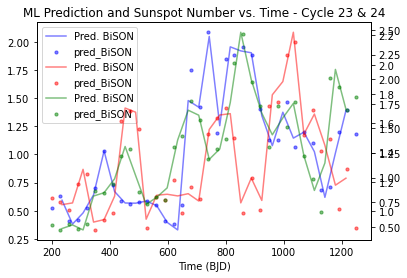

In [ ]:
figure, axis_1 = plt.subplots()
plt.xlabel('Time (BJD)')
plt.title('ML Prediction and Sunspot Number vs. Time - Cycle 23 & 24')

lc_testx = np.arange(200,int(len(pred_lc))*30+200,30)



#Axis 1
axis_1.autoscale(enable=True, axis='both', tight=None)
axis_1.scatter(lc_testx,pred_lc, s = 10, c='blue', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc]).T,30)
axis_1.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='blue', alpha=0.5, label = "Pred. BiSON")


# #Axis 2
axis_2 = axis_1.twinx()
axis_2.scatter(lc_testx,pred_lc2, s = 10, c='red', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc2]).T,30)
axis_2.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='red', alpha=0.5, label = "Pred. BiSON")


# #Axis 3
axis_3 = axis_1.twinx()
axis_3.scatter(lc_testx,pred_lc3, s = 10, c='green', alpha=0.5, label="pred_BiSON")
x1_ITP, y1_ITP = interpolate(np.array([lc_testx,pred_lc3]).T,30)
axis_3.plot(x1_ITP[1:-1], y1_ITP[1:-1], c='green', alpha=0.5, label = "Pred. BiSON")

#Append Labels
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines_3, labels_3 = axis_3.get_legend_handles_labels()
lines = lines_1 + lines_2 + lines_3
labels = labels_1 + labels_2 + labels_3
axis_1.legend(lines, labels, loc=0)


plt.show